In [1]:
import numpy as np

arr = np.load("ch2_ohr_ncp_20200825T1127278043_d_img_d18.npz", allow_pickle= True)['arr_0']

In [2]:
arr

array([[87, 85, 87, ...,  0,  0,  0],
       [90, 85, 87, ...,  0,  0,  0],
       [99, 92, 91, ..., 35, 31, 24],
       ...,
       [46, 49, 48, ..., 23, 19, 17],
       [42, 44, 40, ..., 24, 23, 22],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [3]:
arr.shape

(93693, 12000)

In [4]:
arr = np.float32(arr)

In [5]:
# arr = arr[:18688,:2304]

In [6]:
arr.shape

(93693, 12000)

In [8]:
# Define the size of the 2D array
m, p = 93632, 11968

# Define the size of the 3D array
n = m * p // (64 * 64)
result = np.zeros((n, 64, 64))

# Convert the 2D array to a 3D array
for i in range(n):
    x = (i * 64) % p
    y = (i * 64) // p * 64
    result[i] = arr[y:y+64, x:x+64]/255

print(result.shape)

(273581, 64, 64)


In [13]:
result=np.reshape(result,(273581,64,64,1))

In [33]:
train = result[:10000]
test = result[10000:12000]

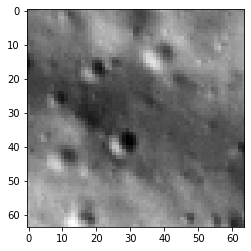

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train[677], cmap='gray')

In [35]:
import keras
import tensorflow 
from keras.utils import plot_model
from keras.layers import Input, Flatten, Dense, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Activation, Reshape, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K 
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

ENCODER

In [62]:
encoder_input = Input(shape=(64,64,1), name='encoder_input')

In [63]:
x = encoder_input

In [64]:
n_layers_encoder = 3
input_dim = (64,64,1)
encoder_conv_filters = [32,32,64]
encoder_conv_kernel_size = [3,3,3]
encoder_conv_strides = [1,2,2]
decoder_conv_t_filters = [64,64,1]
decoder_conv_t_kernel_size = [3,3,3]
decoder_conv_t_strides = [2,2,1]


In [65]:
for i in range(n_layers_encoder):
    conv_layer = Conv2D(
    filters = encoder_conv_filters[i]
    , kernel_size = encoder_conv_kernel_size[i]
    , strides = encoder_conv_strides[i]
    , padding = 'same'
    , name = 'encoder_conv_' + str(i)
    )
    x = conv_layer(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

In [66]:
shape_before_flattening = K.int_shape(x)[1:]
encoder_output = Flatten()(x)

In [67]:
encoder = Model(encoder_input,encoder_output)


In [68]:
encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 64, 64, 1)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_14 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_15 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                          

DECODER

In [69]:
decoder_input = Input(shape=(4096,), name='encoder_output')

In [70]:
# x = Dense(np.prod(shape_before_flattening))(encoder_output) 
x = Reshape(shape_before_flattening)(encoder_output)

In [71]:
n_layers_decoder=3
for i in range(n_layers_decoder):
    conv_t_layer = Conv2DTranspose(
    filters = decoder_conv_t_filters[i]
    ,kernel_size = decoder_conv_t_kernel_size[i]
    ,strides = decoder_conv_t_strides[i]
    ,padding = 'same'
    ,name = 'decoder_conv_t_' + str(i)
    )
    x = conv_t_layer(x) 
    if (i < n_layers_decoder - 1):
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
    else:
        x = Activation('sigmoid')(x)


In [72]:
decoder_output = x

In [73]:
model = Model(encoder_input,decoder_output)

In [74]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 64, 64, 1)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_14 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_15 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                          

In [75]:
r_factor=1
kl_factor = 0.000001

def vae_r_loss(y_true, y_pred):
    r_loss = keras.losses.MeanSquaredError()(y_true, y_pred)
    return r_loss

def vae_kl_loss(y_true, y_pred):
    x=encoder(y_true)
    mu, log_var = tensorflow.split(x, num_or_size_splits=2, axis = 1)
    kl_loss = -0.5 * K.mean(1 + log_var - K.square(mu)- K.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred):
    r_loss = vae_r_loss(y_true, y_pred)
    kl_loss = vae_kl_loss(y_true, y_pred)
    return r_factor*r_loss + kl_factor*kl_loss


In [76]:
optimizer = Adam()
model.compile(optimizer = optimizer, loss = vae_loss)

In [77]:
history = model.fit(train, train, batch_size= 100, shuffle= True, epochs= 20)

Epoch 1/20
100/100 [==============================] - 89s 886ms/step - loss: 0.0040
Epoch 2/20
100/100 [==============================] - 91s 910ms/step - loss: 4.0289e-04
Epoch 3/20
100/100 [==============================] - 92s 918ms/step - loss: 3.0831e-04
Epoch 4/20
100/100 [==============================] - 94s 937ms/step - loss: 2.9197e-04
Epoch 5/20
100/100 [==============================] - 89s 888ms/step - loss: 2.9421e-04
Epoch 6/20
100/100 [==============================] - 90s 901ms/step - loss: 2.1828e-04
Epoch 7/20
100/100 [==============================] - 92s 916ms/step - loss: 2.1789e-04
Epoch 8/20
100/100 [==============================] - 91s 909ms/step - loss: 2.0040e-04
Epoch 9/20
100/100 [==============================] - 89s 888ms/step - loss: 1.6764e-04
Epoch 10/20
100/100 [==============================] - 87s 869ms/step - loss: 1.6019e-04
Epoch 11/20
100/100 [==============================] - 87s 866ms/step - loss: 2.0246e-04
Epoch 12/20
100/100 [=============

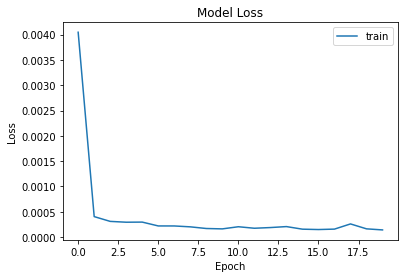

In [78]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [79]:
final = model.predict(
    test,
    batch_size = None,
    verbose = 'auto',
    steps = None,
    callbacks = None,
    max_queue_size = 10,
    workers = 1,
    use_multiprocessing=False
)

63/63 [==============================] - 5s 74ms/step


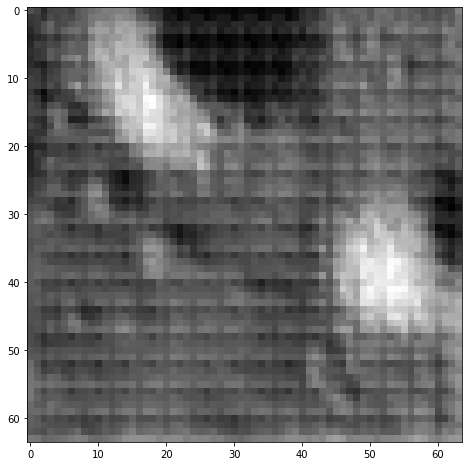

In [106]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(final[406], cmap='gray')

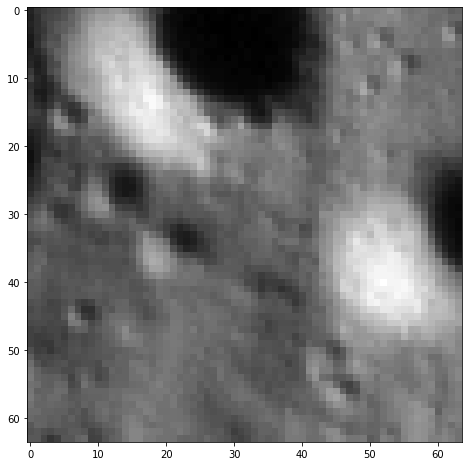

In [107]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(test[406], cmap='gray')


In [105]:
test_results = model.evaluate(test, test, verbose=0)

# Extract the test accuracy from the results
test_acc = test_results

# Calculate the score as the product of test accuracy and 100
score = test_acc * 100

# Print the test accuracy and score
print('Test Accuracy:', test_acc)
print('Score:', score)

Test Accuracy: 0.0021389632020145655
Score: 0.21389632020145655


In [96]:
encoded = encoder.predict(train)

313/313 [==============================] - 7s 21ms/step


C:\Users\Naina\AppData\Local\Temp/ipykernel_10984/1135201232.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(encoded[:,0], encoded[:,1], s=2, cmap='hsv')


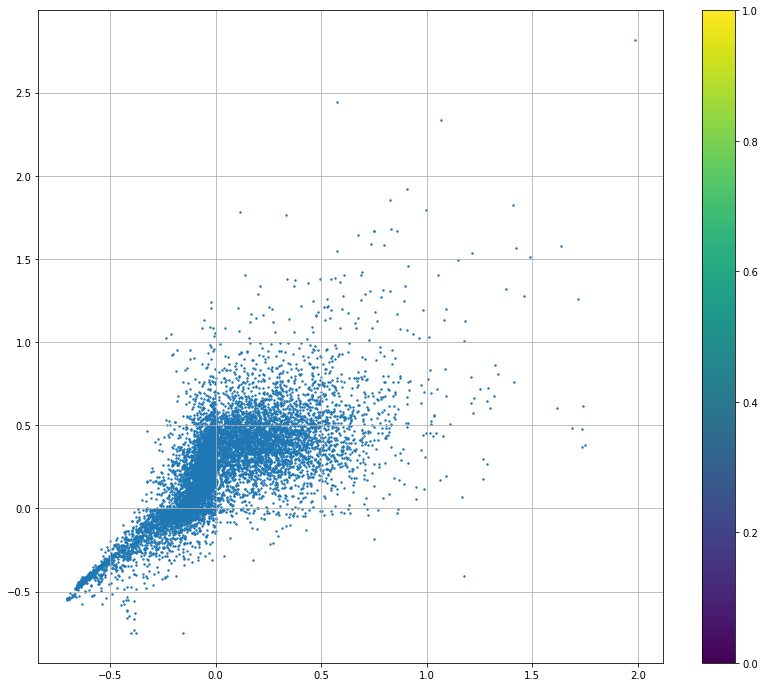

In [97]:
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, cmap='hsv')
plt.colorbar()
plt.grid()
plt.show()